In [1]:
import numpy as np
import math
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import string

In [2]:
def process_text(s):

    # Check string to see if they are a punctuation
    nopunc = [char for char in s if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Convert string to lowercase and remove stopwords
    clean_string = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    return clean_string

In [16]:
#Reading Data
train_data=pd.read_csv('Constraint_Train.csv')

In [17]:
train_data.head()

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


In [18]:
train_data.groupby('label').count()

,id,tweet
label,,
fake,3060,3060
real,3360,3360


In [33]:
test_data=pd.read_csv('english_text_with_labels.csv')

In [34]:
test_data.head()

,id,tweet,label
0,1,Our daily update is published. States reported...,real
1,2,Alfalfa is the only cure for COVID-19.,fake
2,3,President Trump Asked What He Would Do If He W...,fake
3,4,States reported 630 deaths. We are still seein...,real
4,5,This is the sixth time a global health emergen...,real


In [35]:
test_data.groupby('label').count()

,id,tweet
label,,
fake,1020,1020
real,1120,1120


In [19]:
train_data['tweet_cleaned'] = news['tweet'].apply(process_text)


In [20]:
train_data.head()

,id,tweet,label,tweet_cleaned
0,1,The CDC currently reports 99031 deaths. In gen...,real,"[CDC, currently, reports, 99031, deaths, gener..."
1,2,States reported 1121 deaths a small rise from ...,real,"[States, reported, 1121, deaths, small, rise, ..."
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake,"[Politically, Correct, Woman, Almost, Uses, Pa..."
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real,"[IndiaFightsCorona, 1524, COVID, testing, labo..."
4,5,Populous states can generate large case counts...,real,"[Populous, states, generate, large, case, coun..."


In [14]:
from sklearn.feature_extraction.text import CountVectorizer

In [15]:
bow_transformer = CountVectorizer(analyzer=process_text).fit(train_data['tweet_cleaned'])

print(len(bow_transformer.vocabulary_)) #Total vocab words

6390


In [26]:
news_train_bow = bow_transformer.transform(train_data['tweet_cleaned'])

In [24]:
print('Shape of Sparse Matrix: ', news_train_bow.shape)
print('Amount of Non-Zero occurences: ', news_train_bow.nnz)


Shape of Sparse Matrix:  (6420, 6390)
Amount of Non-Zero occurences:  6420


In [25]:
sparsity = (100.0 * news_bow.nnz / (news_train_bow.shape[0] * news_train_bow.shape[1]))
print('sparsity: {}'.format(round(sparsity)))


sparsity: 0


In [27]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(news_train_bow)
train_news_tfidf = tfidf_transformer.transform(news_train_bow)
print(train_news_tfidf.shape)

(6420, 6390)


In [30]:
#Train Naive Bayes Model
from sklearn.naive_bayes import MultinomialNB
fakenews_detect_model = MultinomialNB().fit(train_news_tfidf, news['label'])

In [31]:
#Model Evaluation
predictions = fakenews_detect_model.predict(train_news_tfidf)
print(predictions)


['real' 'real' 'fake' ... 'fake' 'fake' 'real']


In [32]:
from sklearn.metrics import classification_report
print (classification_report(train_data['label'], predictions))

              precision    recall  f1-score   support

        fake       1.00      1.00      1.00      3060
        real       1.00      1.00      1.00      3360

    accuracy                           1.00      6420
   macro avg       1.00      1.00      1.00      6420
weighted avg       1.00      1.00      1.00      6420



In [36]:
news_train= train_data['tweet']
news_test= test_data['tweet']
label_train=train_data['label']
label_test=test_data['label']

In [39]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=process_text)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])
pipeline.fit(news_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function process_text at 0x7f8bac870ee0>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [40]:
predictions = pipeline.predict(news_test)


In [41]:
print(classification_report(predictions,label_test))


              precision    recall  f1-score   support

        fake       0.85      0.95      0.90       921
        real       0.96      0.88      0.92      1219

    accuracy                           0.91      2140
   macro avg       0.91      0.91      0.91      2140
weighted avg       0.91      0.91      0.91      2140



In [42]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(label_test, predictions)

print('Confusion matrix\n\n', cm)

print('\nTrue Positives(TP) = ', cm[0,0])

print('\nTrue Negatives(TN) = ', cm[1,1])

print('\nFalse Positives(FP) = ', cm[0,1])

print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[ 872  148]
 [  49 1071]]

True Positives(TP) =  872

True Negatives(TN) =  1071

False Positives(FP) =  148

False Negatives(FN) =  49


<AxesSubplot:>

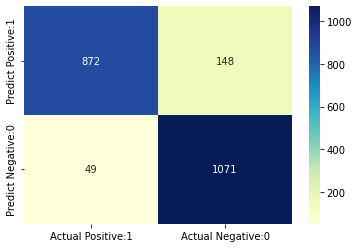

In [43]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')